In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import r_regression
from scipy.stats import pearsonr

In [52]:

def get_by_char(char='R', num=3):
    return pd.read_csv(f'./{char}/{char}_chunks_{num}.csv')

In [3]:
df_r = get_by_char('R')
df_g = get_by_char('G')

In [4]:
x = df_g.iloc[:, 0:60].to_numpy()
y = df_g.iloc[:,61].to_numpy()

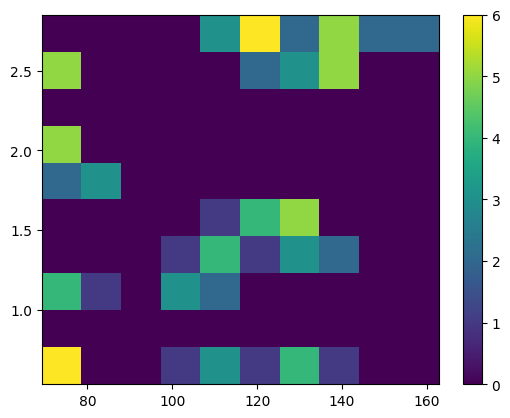

In [13]:
plt.hist2d(np.mean(x, axis=1), y, bins=10)
plt.colorbar()
plt.show()

In [ ]:
r_regression(np.max(x, axis=1).reshape(-1,1), y)

array([0.33188741])

In [53]:
for p in range(3, 13):
    df = get_by_char('G', p)
    x = df_g.iloc[:, 0:60].to_numpy()
    y = df_g.iloc[:,61].to_numpy()
    k = pearsonr(np.median(x, axis=1).reshape(-1), y)
    print(f'pearsons_r for {p}-th person = {k}')

pearsons_r for 3-th person = PearsonRResult(statistic=np.float64(0.3417812802914756), pvalue=np.float64(0.0008547077041903311))
pearsons_r for 4-th person = PearsonRResult(statistic=np.float64(0.3417812802914756), pvalue=np.float64(0.0008547077041903311))
pearsons_r for 5-th person = PearsonRResult(statistic=np.float64(0.3417812802914756), pvalue=np.float64(0.0008547077041903311))
pearsons_r for 6-th person = PearsonRResult(statistic=np.float64(0.3417812802914756), pvalue=np.float64(0.0008547077041903311))
pearsons_r for 7-th person = PearsonRResult(statistic=np.float64(0.3417812802914756), pvalue=np.float64(0.0008547077041903311))
pearsons_r for 8-th person = PearsonRResult(statistic=np.float64(0.3417812802914756), pvalue=np.float64(0.0008547077041903311))
pearsons_r for 9-th person = PearsonRResult(statistic=np.float64(0.3417812802914756), pvalue=np.float64(0.0008547077041903311))
pearsons_r for 10-th person = PearsonRResult(statistic=np.float64(0.3417812802914756), pvalue=np.float64

In [59]:
np.mean(x, axis=1)

array([122.63080842, 109.35182978, 107.81782916, 108.00764316,
       106.48253878, 127.99132619, 135.28967501, 134.12541253,
       132.1400738 , 136.2604241 , 127.20465613, 124.69523908,
       125.01320341, 125.49892263, 127.12303559, 111.49124963,
       114.60949602, 114.46367353, 112.28874768, 103.59918226,
        77.60326895,  73.52620924,  74.06008087,  75.3370591 ,
        76.88153368, 126.37845652, 126.88975678, 125.34163364,
       127.88740174, 127.87017184,  75.03358071,  74.28731011,
        72.47476576,  71.31384995,  71.45572395,  74.02691051,
       102.82184942, 107.03424483, 110.62353642, 102.43320479,
       100.02122552, 133.0647307 , 114.80114877, 112.9061595 ,
       123.12455724, 119.18792367, 118.31226535, 119.38922896,
       115.89537142, 119.16557162, 117.54239891, 158.45000497,
       162.7052821 , 136.44747377, 140.41624035, 140.92939221,
        80.73749959,  77.75609611,  77.78301537,  78.52920972,
        77.60515296, 134.34255823, 134.99985883, 134.18

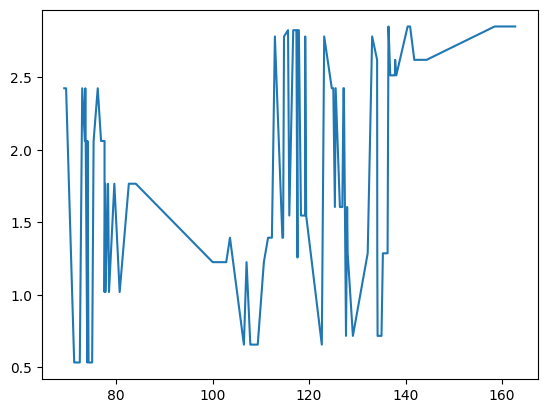

In [62]:
x_m = x.mean(axis=1)
args = np.argsort(x_m)
x_m = x_m[args]
y = y[args]

plt.plot(x_m, y)